In [15]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy

In [21]:
journey_profiles = pandas.read_parquet("journey_profiles")
journey_profiles.loc[journey_profiles["INCLUDES_MAX"]==1,"INCLUDES_MAX"] = "Yes"
journey_profiles.loc[journey_profiles["INCLUDES_MAX"]==0,"INCLUDES_MAX"] = "No"
journey_profiles.loc[journey_profiles["IS_MAX_ONLY"]==1,"IS_MAX_ONLY"] = "Yes"
journey_profiles.loc[journey_profiles["IS_MAX_ONLY"]==0,"IS_MAX_ONLY"] = "No"
journey_profiles["ORIGIN_DESTINATION_DISTANCE_FT"] = journey_profiles["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3
journey_profiles.loc[journey_profiles["IS_SINGLE_STOP_RIDE"]==1,"IS_SINGLE_STOP_RIDE"] = "Yes"
journey_profiles.loc[journey_profiles["IS_SINGLE_STOP_RIDE"]==0,"IS_SINGLE_STOP_RIDE"] = "No"

# Evaluate effectiveness of Loop Tag

In [22]:
#loop tag analysis
print(
    journey_profiles.groupby(["IS_SINGLE_STOP_RIDE"])["ORIGIN_DESTINATION_DISTANCE_FT"].describe(
    percentiles = [x/100 for x in range(0,100,10)]).T,
    "\n",
    journey_profiles[
        journey_profiles["ORIGIN_DESTINATION_DISTANCE_FT"]<200
        ].groupby(["IS_SINGLE_STOP_RIDE"],as_index = False)["JOURNEY_ID"].count().T
    )


IS_SINGLE_STOP_RIDE            No            Yes
count                1.360735e+06  149912.000000
mean                 1.892192e+04    2645.849212
std                  1.451086e+04    2554.391392
min                  0.000000e+00     166.514648
0%                   0.000000e+00     166.514648
10%                  4.249722e+03     756.625691
20%                  6.847544e+03     956.758243
30%                  9.594317e+03    1121.400965
40%                  1.248121e+04    1316.757742
50%                  1.549330e+04    1507.895005
60%                  1.890402e+04    2214.896122
70%                  2.333242e+04    2796.769378
80%                  2.892949e+04    3928.098218
90%                  3.749068e+04    6260.016008
max                  1.747347e+05   16565.859459 
                         0    1
IS_SINGLE_STOP_RIDE    No  Yes
JOURNEY_ID           6127    4


# Calculate Validity Score and analyze

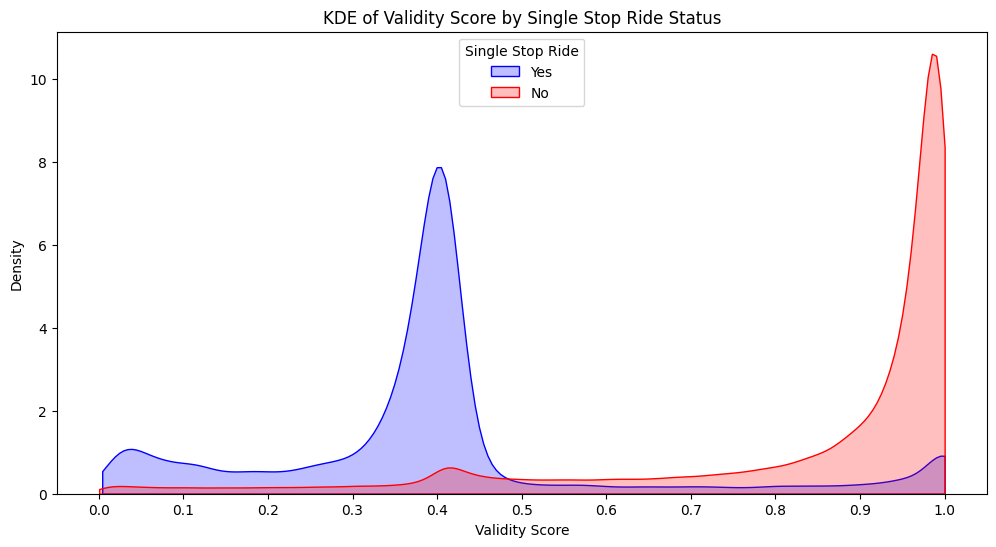

In [23]:
# Create the KDE plot
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=journey_profiles[journey_profiles["IS_SINGLE_STOP_RIDE"] == "Yes"], 
    x="VALIDITY_SCORE", 
    color="blue",
    fill=True,
    label="Yes",
    cut=0
)

sns.kdeplot(
    data=journey_profiles[journey_profiles["IS_SINGLE_STOP_RIDE"] == "No"], 
    x="VALIDITY_SCORE", 
    color="red",
    fill=True,
    label="No",
    cut=0
)

plt.legend(title = "Single Stop Ride", loc='upper center')
plt.title("KDE of Validity Score by Single Stop Ride Status")
plt.xlabel("Validity Score")
plt.ylabel("Density")

# Limit x-axis to focus on the main distribution
plt.xticks(numpy.arange(0,1+.10,0.1))

plt.show()

In [24]:
journey_profiles.groupby(
    by = ["IS_SINGLE_STOP_RIDE"]
    )["VALIDITY_SCORE"].describe(
        percentiles = [x/100 for x in range(0,100,10)]
        ).T

IS_SINGLE_STOP_RIDE,No,Yes
count,1.360735e+06,149912.000000
mean,8.409565e-01,0.400488
std,2.337038e-01,0.220992
min,4.803905e-04,0.004073
0%,4.803905e-04,0.004073
10%,4.397295e-01,0.110245
20%,7.102962e-01,0.275386
30%,8.633830e-01,0.354655
40%,9.267075e-01,0.381612
50%,9.568754e-01,0.396996


# Analyze impacts of Validity Score Cutoffs

In [25]:
#impact of validity score cutoff of 0.50
cutoff = 0.50
journey_profiles["ABOVE_CUTOFF"] = journey_profiles["VALIDITY_SCORE"] > cutoff
median_distance_above_cutoff = (journey_profiles[journey_profiles["ABOVE_CUTOFF"]]["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (journey_profiles["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (journey_profiles[journey_profiles["ABOVE_CUTOFF"]]["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (journey_profiles["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = journey_profiles[journey_profiles["ABOVE_CUTOFF"]]["N_LEGS"].mean()-1
mean_n_transfers = journey_profiles["N_LEGS"].mean()-1
n_bus_only = len(journey_profiles[journey_profiles["INCLUDES_MAX"]=="No"])
n_bus_and_max = len(journey_profiles[(journey_profiles["INCLUDES_MAX"]=="Yes")&(~(journey_profiles["IS_MAX_ONLY"]=="Yes"))])
n_max_only = len(journey_profiles[journey_profiles["IS_MAX_ONLY"] == "Yes"])
n_bus_only_above_cutoff = len(journey_profiles[(journey_profiles["INCLUDES_MAX"]=="No") & (journey_profiles["ABOVE_CUTOFF"])])
n_bus_and_max_above_cutoff = len(journey_profiles[(journey_profiles["INCLUDES_MAX"]=="Yes") & (~(journey_profiles["IS_MAX_ONLY"]=="Yes")) & (journey_profiles["ABOVE_CUTOFF"])])
n_max_only_above_cutoff = len(journey_profiles[(journey_profiles["IS_MAX_ONLY"] == "Yes") & (journey_profiles["ABOVE_CUTOFF"])])
n_single_stop_journeys = len(journey_profiles[journey_profiles["IS_SINGLE_STOP_RIDE"]=="Yes"])
n_single_stop_journeys_above_cutoff = len(journey_profiles[(journey_profiles["IS_SINGLE_STOP_RIDE"]=="Yes")&journey_profiles["ABOVE_CUTOFF"]])

# Create a table of statistics
stats_table = {
    "Statistic": [
        "Number of Journeys",
        "Number of Single Stop Rides",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers",
        "Bus Only Journeys",
        "Bus and MAX Journeys",
        "MAX Only Journeys"
    ],"All Journeys": [
        f"{len(journey_profiles)}",
        f"{n_single_stop_journeys}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}",
        f"{n_bus_only}",
        f"{n_bus_and_max}",
        f"{n_max_only}"
    ],
    "Above Cutoff": [
        f"{len(journey_profiles[journey_profiles['ABOVE_CUTOFF']])}",
        f"{n_single_stop_journeys_above_cutoff}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}",
        f"{n_bus_only_above_cutoff}",
        f"{n_bus_and_max_above_cutoff}",
        f"{n_max_only_above_cutoff}"
    ],
    "Percent Change": [
        f"{(len(journey_profiles[journey_profiles['ABOVE_CUTOFF']])-len(journey_profiles))/len(journey_profiles)*100:.2f}",
        f"{(n_single_stop_journeys_above_cutoff-n_single_stop_journeys)/n_single_stop_journeys*100:.2f}",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%",
        f"{(n_bus_only_above_cutoff - n_bus_only) / n_bus_only * 100:.2f}%",
        f"{(n_bus_and_max_above_cutoff - n_bus_and_max) / n_bus_and_max * 100:.2f}%",
        f"{(n_max_only_above_cutoff - n_max_only) / n_max_only * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
stats_df = pandas.DataFrame(stats_table)

# Print the formatted table
print(stats_df.to_string(index=False))


                    Statistic All Journeys Above Cutoff Percent Change
           Number of Journeys      1510647      1214414         -19.61
  Number of Single Stop Rides       149912        21755         -85.49
      Median Distance (miles)         2.62         2.93         11.70%
Median Journey Time (minutes)        17.58        19.42         10.43%
     Mean Number of Transfers         0.28         0.30          7.89%
            Bus Only Journeys      1198929      1006421        -16.06%
         Bus and MAX Journeys        41368        34570        -16.43%
            MAX Only Journeys       270350       173423        -35.85%


In [ ]:
journey_profiles[
    (journey_profiles["IS_SINGLE_STOP_RIDE"]==1)
    ]["VALIDITY_SCORE"]

0          0.225628
13         0.380461
30         0.799636
38         0.420521
39         0.414769
             ...   
1514166    0.349966
1514169    0.009426
1514177    0.356147
1514186    0.194571
1514199    0.306549
Name: VALIDITY_SCORE, Length: 133194, dtype: float64

# Analyze Confidence Scores

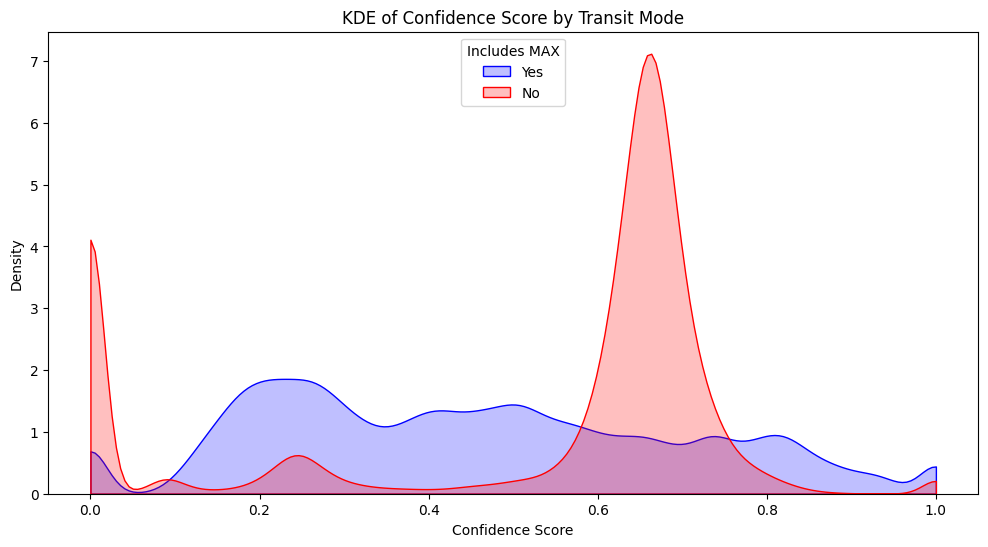

In [26]:
# Create the KDE plot
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=journey_profiles[journey_profiles["INCLUDES_MAX"] == "Yes"], 
    x="CONFIDENCE_MIN", 
    color="blue",
    fill=True,
    label="Yes",
    cut=0
)

sns.kdeplot(
    data=journey_profiles[journey_profiles["INCLUDES_MAX"] == "No"], 
    x="CONFIDENCE_MIN", 
    color="red",
    fill=True,
    label="No",
    cut=0
)

plt.legend(title = "Includes MAX", loc='upper center')
plt.title("KDE of Confidence Score by Transit Mode")
plt.xlabel("Confidence Score")
plt.ylabel("Density")


plt.show()

In [27]:
#analyze confidence score cutoffs
journey_profiles.groupby(
    ["INCLUDES_MAX"],as_index=False
    )["CONFIDENCE_MIN"].describe(percentiles = [x/100 for x in range(0,100,10)]).T

,0,1
INCLUDES_MAX,No,Yes
count,1198929.0,311718.0
mean,0.518726,0.456414
std,0.267525,0.245209
min,0.0,0.0
0%,0.0,0.0
10%,0.0,0.169777
20%,0.230227,0.224573
30%,0.588243,0.278387
40%,0.628585,0.357948


# Analyze impacts of confidence score cutoffs

In [28]:
#evaluate impact of cutoff of 0.50 on bus only journeys
cutoff = 0.50
bus_only = journey_profiles[journey_profiles["INCLUDES_MAX"] == "No"]
bus_only["ABOVE_CUTOFF"] = bus_only["CONFIDENCE_MIN"] > cutoff
median_distance_above_cutoff = (bus_only[bus_only["ABOVE_CUTOFF"]]["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (bus_only["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (bus_only[bus_only["ABOVE_CUTOFF"]]["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (bus_only["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = bus_only[bus_only["ABOVE_CUTOFF"]]["N_LEGS"].mean()-1
mean_n_transfers = bus_only["N_LEGS"].mean()-1
# Calculate the number of journeys
journey_count_above_cutoff = bus_only["ABOVE_CUTOFF"].sum()
total_journey_count = len(bus_only)


# Create a table of statistics
stats_table = {
    "Statistic": [
        "Journey Count",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers"
    ],
    "All Journeys": [
        f"{total_journey_count}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}"
    ],
    "Above Cutoff": [
        f"{journey_count_above_cutoff}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}"
    ],
    "Percent Change": [
        f"{(journey_count_above_cutoff - total_journey_count) / total_journey_count * 100:.2f}%",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
stats_df = pandas.DataFrame(stats_table)

# Print the formatted table
print(stats_df.to_string(index=False))




/var/folders/ky/ppnwhmms1wd68gb7bjq21xd40000gn/T/ipykernel_28688/3286303238.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_only["ABOVE_CUTOFF"] = bus_only["CONFIDENCE_MIN"] > cutoff


                    Statistic All Journeys Above Cutoff Percent Change
                Journey Count      1198929       889019        -25.85%
      Median Distance (miles)         2.63         2.42         -7.76%
Median Journey Time (minutes)        18.55        16.87         -9.07%
     Mean Number of Transfers         0.30         0.30         -1.12%


In [29]:
#evaluate impact of cutoff of 0.20 on includes max journeys
cutoff = 0.20
includes_max = journey_profiles[(journey_profiles["INCLUDES_MAX"] == "Yes") &(journey_profiles["IS_MAX_ONLY"] == False) ]
includes_max["ABOVE_CUTOFF"] = includes_max["CONFIDENCE_MIN"] > cutoff
median_distance_above_cutoff = (includes_max[includes_max["ABOVE_CUTOFF"]]["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (includes_max["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (includes_max[includes_max["ABOVE_CUTOFF"]]["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (includes_max["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = includes_max[includes_max["ABOVE_CUTOFF"]]["N_LEGS"].mean()-1
mean_n_transfers = includes_max["N_LEGS"].mean()-1
journey_count_above_cutoff = includes_max["ABOVE_CUTOFF"].sum()
total_journey_count = len(includes_max)

# Create a table of statistics
stats_table = {
    "Statistic": [
        "Journey Count",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers"
    ],
    "All Journeys": [
        f"{total_journey_count}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}"
    ],
    "Above Cutoff": [
        f"{journey_count_above_cutoff}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}"
    ],
    "Percent Change": [
        f"{(journey_count_above_cutoff - total_journey_count) / total_journey_count * 100:.2f}%",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
stats_df = pandas.DataFrame(stats_table)

# Print the formatted table
print(stats_df.to_string(index=False))

                    Statistic All Journeys Above Cutoff Percent Change
                Journey Count            0            0           nan%
      Median Distance (miles)          nan          nan           nan%
Median Journey Time (minutes)          nan          nan           nan%
     Mean Number of Transfers          nan          nan           nan%


/var/folders/ky/ppnwhmms1wd68gb7bjq21xd40000gn/T/ipykernel_28688/1016545369.py:35: RuntimeWarning: invalid value encountered in scalar divide
  f"{(journey_count_above_cutoff - total_journey_count) / total_journey_count * 100:.2f}%",


In [30]:
# Evaluate impact of cutoff on MAX-only journeys
cutoff = 0.20
max_only = journey_profiles[journey_profiles["IS_MAX_ONLY"] == True]
max_only["ABOVE_CUTOFF"] = max_only["CONFIDENCE_MIN"] > cutoff
median_distance_above_cutoff = (max_only[max_only["ABOVE_CUTOFF"]]["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (max_only["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (max_only[max_only["ABOVE_CUTOFF"]]["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (max_only["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = max_only[max_only["ABOVE_CUTOFF"]]["N_LEGS"].mean()-1
mean_n_transfers = max_only["N_LEGS"].mean()-1
journey_count_above_cutoff = max_only["ABOVE_CUTOFF"].sum()
total_journey_count = len(max_only)

# Create a table of statistics for MAX-only journeys
max_only_stats_table = {
    "Statistic": [
        "Journey Count",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers"
    ],
    "All MAX-only Journeys": [
        f"{total_journey_count}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}"
    ],
    "Above Cutoff": [
        f"{journey_count_above_cutoff}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}"
    ],
    "Percent Change": [
        f"{(journey_count_above_cutoff - total_journey_count) / total_journey_count * 100:.2f}%",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
max_only_stats_df = pandas.DataFrame(max_only_stats_table)

# Print the formatted table for MAX-only journeys
print("Statistics for MAX-only Journeys:")
print(max_only_stats_df.to_string(index=False))


Statistics for MAX-only Journeys:
                    Statistic All MAX-only Journeys Above Cutoff Percent Change
                Journey Count                     0            0           nan%
      Median Distance (miles)                   nan          nan           nan%
Median Journey Time (minutes)                   nan          nan           nan%
     Mean Number of Transfers                   nan          nan           nan%


/var/folders/ky/ppnwhmms1wd68gb7bjq21xd40000gn/T/ipykernel_28688/3383985444.py:35: RuntimeWarning: invalid value encountered in scalar divide
  f"{(journey_count_above_cutoff - total_journey_count) / total_journey_count * 100:.2f}%",


# Analyze Impacts of combined Validity and Confidence score Cutoffs



In [32]:
# Define cutoffs for both validity and confidence scores
validity_cutoff = 0.5  # You can adjust this value as needed
confidence_cutoff_no_max = 0.5  # Confidence cutoff for journeys without max
confidence_cutoff_with_max = 0.2  # Confidence cutoff for journeys with max

# Create a new DataFrame with both cutoffs applied
combined_cutoff = journey_profiles[
    (journey_profiles["VALIDITY_SCORE"] > validity_cutoff) & 
    (
        ((journey_profiles['INCLUDES_MAX'] == 'No') & 
         (journey_profiles['CONFIDENCE_MIN'] > confidence_cutoff_no_max)) |
        ((journey_profiles['INCLUDES_MAX'] == 'Yes') & 
         (journey_profiles['CONFIDENCE_MIN'] > confidence_cutoff_with_max))
    )
]
total_n_journeys = len(journey_profiles)
total_n_journeys_above_cutoff = len(combined_cutoff)
median_distance_above_cutoff = (combined_cutoff["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_distance = (journey_profiles["ORIGIN_DESTINATION_DISTANCE_METERS"]*3.3).median()/5280
median_journey_time_above_cutoff = (combined_cutoff["JOURNEY_TIME_SECONDS"]/60).median()
median_journey_time = (journey_profiles["JOURNEY_TIME_SECONDS"]/60).median()
mean_n_transfers_above_cutoff = combined_cutoff["N_LEGS"].mean()-1
mean_n_transfers = journey_profiles["N_LEGS"].mean()-1
n_bus_only = len(journey_profiles[journey_profiles["INCLUDES_MAX"]=="No"])
n_bus_and_max = len(
    journey_profiles[
        (journey_profiles["INCLUDES_MAX"]=="Yes")&
        (~(journey_profiles["IS_MAX_ONLY"]=="Yes"))
        ])
n_max_only = len(journey_profiles[journey_profiles["IS_MAX_ONLY"] == "Yes"])
n_bus_only_above_cutoff = len(combined_cutoff[(combined_cutoff["INCLUDES_MAX"]=="No")])
n_bus_and_max_above_cutoff = len(
    combined_cutoff[
        (combined_cutoff["INCLUDES_MAX"]=="Yes") & 
        (~(combined_cutoff["IS_MAX_ONLY"]=="Yes"))
        ])
n_max_only_above_cutoff = len(combined_cutoff[(combined_cutoff["IS_MAX_ONLY"] == "Yes")])
n_single_stop = len(journey_profiles[journey_profiles["IS_SINGLE_STOP_RIDE"] == "Yes"])
n_single_stop_above_cutoff = len(combined_cutoff[combined_cutoff["IS_SINGLE_STOP_RIDE"] == "Yes"])

# Create a table of statistics
stats_table = {
    "Statistic": [
        "Total Number of Journeys",
        "Median Distance (miles)",
        "Median Journey Time (minutes)",
        "Mean Number of Transfers",
        "Bus Only Journeys",
        "Bus and MAX Journeys",
        "MAX Only Journeys",
        "Single Stop Rides"
    ],
    "All Journeys": [
        f"{total_n_journeys:.2f}",
        f"{median_distance:.2f}",
        f"{median_journey_time:.2f}",
        f"{mean_n_transfers:.2f}",
        f"{n_bus_only}",
        f"{n_bus_and_max}",
        f"{n_max_only}",
        f"{n_single_stop}"
    ],
    "Above Cutoff": [
        f"{total_n_journeys_above_cutoff:.2f}",
        f"{median_distance_above_cutoff:.2f}",
        f"{median_journey_time_above_cutoff:.2f}",
        f"{mean_n_transfers_above_cutoff:.2f}",
        f"{n_bus_only_above_cutoff}",
        f"{n_bus_and_max_above_cutoff}",
        f"{n_max_only_above_cutoff}",
        f"{n_single_stop_above_cutoff}"
    ],
    "Percent Change": [
        f"{(total_n_journeys_above_cutoff - total_n_journeys) / total_n_journeys * 100:.2f}%",
        f"{(median_distance_above_cutoff - median_distance) / median_distance * 100:.2f}%",
        f"{(median_journey_time_above_cutoff - median_journey_time) / median_journey_time * 100:.2f}%",
        f"{(mean_n_transfers_above_cutoff - mean_n_transfers) / mean_n_transfers * 100:.2f}%",
        f"{(n_bus_only_above_cutoff - n_bus_only) / n_bus_only * 100:.2f}%",
        f"{(n_bus_and_max_above_cutoff - n_bus_and_max) / n_bus_and_max * 100:.2f}%",
        f"{(n_max_only_above_cutoff - n_max_only) / n_max_only * 100:.2f}%",
        f"{(n_single_stop_above_cutoff - n_single_stop) / n_single_stop * 100:.2f}%"
    ]
}

# Convert to DataFrame for easy printing
stats_df = pandas.DataFrame(stats_table)

# Print the formatted table
print(stats_df.to_string(index=False))

TypeError: bad operand type for unary ~: 'str'

In [86]:
journey_profiles.iloc[0]

JOURNEY_ID                                        000010ad81e49c188f125a97cfbced04d37eb164e90862...
CARD_ID                                                        9b028307-959b-fec1-6a25-986c46dc55a1
VALIDITY_SCORE                                                                             0.225628
ALIGHTING_TO_NEXT_BOARDING_DISTANCE_METERS_MAX                                                  NaN
ALIGHTING_TO_NEXT_BOARDING_DISTANCE_METERS_MIN                                                  NaN
N_LEGS                                                                                            1
LEG_DISTANCE_METERS_MIN                                                                 2582.625996
LEG_DISTANCE_METERS_MAX                                                                 2582.625996
TOTAL_JOURNEY_DISTANCE_TRAVELED_METERS                                                  2582.625996
ORIGIN_DESTINATION_DISTANCE_METERS                                                      2582.625996
